In [1]:
# ## Environment and packages
# cd(@__DIR__)
using Pkg;
# Pkg.activate(".");

using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, Optim
using DiffEqFlux, Flux

using Random
using CSV
using Lux
using DataFrames

using Plots
gr()

Pkg.status()

┌ Info: DataDrivenDiffEq : OccamNet is available.
└ @ DataDrivenDiffEq /Users/adrocampos/.julia/packages/DataDrivenDiffEq/fivVr/src/DataDrivenDiffEq.jl:168


Status `~/covid19/discovering_missing_terms/Project.toml`
  [336ed68f] CSV v0.10.7
⌃ [2445eb08] DataDrivenDiffEq v0.8.6
  [a93c6f00] DataFrames v1.4.3
  [aae7a2af] DiffEqFlux v1.52.0
  [41bf760c] DiffEqSensitivity v6.79.0
  [0c46a032] DifferentialEquations v7.6.0
  [5789e2e9] FileIO v1.16.0
⌃ [587475ba] Flux v0.13.7
  [7073ff75] IJulia v1.23.3
  [033835bb] JLD2 v0.4.28
⌃ [b2108857] Lux v0.4.34
⌃ [961ee093] ModelingToolkit v8.33.0
⌃ [429524aa] Optim v1.7.3
  [7f7a1694] Optimization v3.9.2
  [36348300] OptimizationOptimJL v0.1.4
  [1dea7af3] OrdinaryDiffEq v6.31.2
⌃ [91a5bcdd] Plots v1.36.1
  [e88e6eb3] Zygote v0.6.49
  [8bb1440f] DelimitedFiles
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [2]:
data_dir = "/Users/adrocampos/covid19/synth_data/"
regions = ["2", "3", "5", "10", "15", "20", "30"][1]
mobility_type = ["inv_dist", "border", "neighbor"][2]
initially_recovered = false


file = "1"

csv_reader = CSV.File(data_dir * "SIR_" * regions * "_regions_" * mobility_type * "_" * file * ".csv")
df = DataFrame(csv_reader)


index = range(1, stop=5001, step=100)
df = df[index, :]

X = Matrix(df[:, [:S1, :I1, :R1]])
X = transpose(X)
println("size(X) =", size(X))



tspan = (1, size(X)[2])

t = range(tspan[1], tspan[2], step=1)

u0 = X[:, 1]


size(X) =(3, 51)


3-element Vector{Float64}:
 2773.0
    7.0
    0.0

In [ ]:
println(X)

In [ ]:
X[3,:]

In [ ]:
## Our loss is too big and crazy

In [ ]:
p

In [ ]:
sum([1,2,3])

In [12]:
ann = FastChain(
    FastDense(3,64,tanh), FastDense(64,64,tanh), FastDense(64, 1)
)

p = Float64.(initial_params(ann))


# p_ = [.1, 1/10]

# p_ = rand(Float32, 2)




function dudt!(du, u, p, t)
    
    N = sum(u)
    S, I, R = u
    β = .1
    γ = 1/10 ## with this I fix the initial parameters
    

    z  = ann(u, p)
    
    du[1] = dS = -β* S * I/N - z[1]
    du[2] = dI = β* S * I/N + z[1] - γ*I
    du[3] = dR = γ * I


#     dS, dI, dR = z[1], z[2], z[3]
    [dS, dI, dR]
    
end




## Define the problem
## Prediction with initial random weights
prob_UODE = ODEProblem(dudt!, u0, tspan, p) ##prob_neuralode
s = concrete_solve(prob_UODE, Tsit5(), u0, p, saveat=t)



┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux /Users/adrocampos/.julia/packages/DiffEqFlux/Em1Aj/src/fast_layers.jl:9


retcode: Success
Interpolation: 1st order linear
t: 51-element Vector{Float64}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0
 11.0
 12.0
 13.0
  ⋮
 40.0
 41.0
 42.0
 43.0
 44.0
 45.0
 46.0
 47.0
 48.0
 49.0
 50.0
 51.0
u: 51-element Vector{Vector{Float64}}:
 [2773.0, 7.0, 0.0]
 [2773.2197825013354, 6.124019587874263, 0.6561979107900912]
 [2773.526940367239, 5.248248727061036, 1.224810905699605]
 [2773.921781457252, 4.3723730312272355, 1.705845511520804]
 [2774.4046424615563, 3.496083891471208, 2.0992736469725215]
 [2774.9758608407706, 2.619101768506479, 2.405037390722774]
 [2775.635741224475, 1.741200075729586, 2.623058699795312]
 [2776.384554980372, 0.8622054824423351, 2.753239537185611]
 [2777.222540200193, -0.01800220431662083, 2.795462004123623]
 [2778.1498918890175, -0.8994948001004502, 2.749602911082885]
 [2779.16674255041, -1.782272606410792, 2.6155300560004946]
 [2780.2731805669146, -2.666292650328526, 2.393112083413955]
 [2781.469254221736, -3.5514830866636755, 

In [5]:
## Is the original data the derivatives?

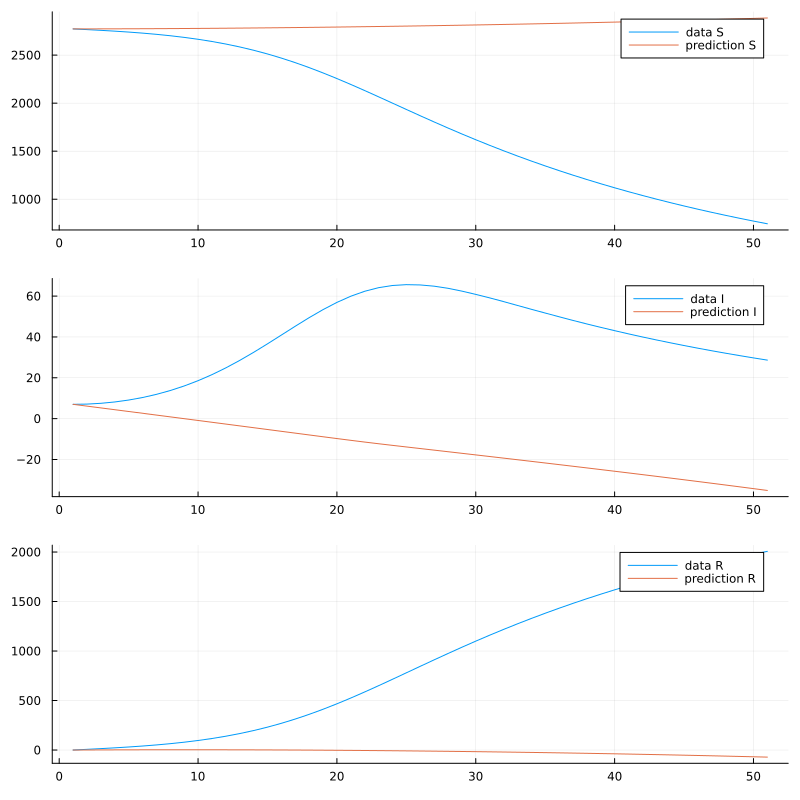

In [16]:
## Function to train the network
# Define a predictor
function predict(θ)
    Array(concrete_solve(prob_UODE, Vern7(), u0=u0, p=θ,
    tspan=tspan, saveat=1, abstol=1e-6, reltol=1e-6,
    sensealg=ForwardDiffSensitivity()
    ))
end
a = predict(p)

pS = plot(t, [X[1,:], a[1,:]], label=["data S" "prediction S"])
pI = plot(t, [X[2,:], a[2,:]], label=["data I" "prediction I"])
pR = plot(t, [X[3,:], a[3,:]], label=["data R" "prediction R"])

display(plot(pS, pI, pR, layout = (3,1), size = (800, 800)))

In [ ]:
## Is loss too small? R/ It is too big!!

In [ ]:
size(X, 2)

In [ ]:
eltype(p)

In [ ]:
convert(eltype(p), 1e-6) * sum(abs2, p[3:end]) ./ length(p[3:end])

In [17]:
## .- instead of -?
function loss(θ)
    X̂ = predict(θ)
    lo = sum(abs2, X .- X̂) / size(X, 2) #+ convert(eltype(θ), 1e-3) * sum(abs2, θ[3:end]) ./ length(θ[3:end])
    return lo
end
loss(p)

2.815354408839091e6

In [ ]:
# Option 1: optimize with sciml

const losses = []
callback(θ,l) = begin
    push!(losses, l)
    println("loss = ", l)

    if length(losses)%5==0
        println(losses[end])
    end
    false
end

res1_uode = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback,  maxiters=100)



┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/adrocampos/.julia/packages/DiffEqFlux/Em1Aj/src/train.jl:6


In [ ]:
preds = predict(res1_uode)
pS = plot(t, [X[1,:], preds[1,:]], label=["data S" "prediction S"])
pI = plot(t, [X[2,:], preds[2,:]], label=["data I" "prediction I"])
pR = plot(t, [X[3,:], preds[3,:]], label=["data R" "prediction R"])
display(plot(pS, pI, pR, layout = (3,1), size = (800, 800)))

In [ ]:
p

In [ ]:
### Our loss is crazy high... why is our loss so crazy high?

In [ ]:
# # Option 2: optimize with Optimization.jl
# losses = Float32[] 

# callback(θ, args...) = begin
#     l = loss(θ) # Equivalent L2 loss
#     push!(losses, l)
#     if length(losses) % 5 == 0
#         println("Current loss after $(length(losses)) iterations: $(losses[end])")
#     end
#     false
# end


# # use Optimization.jl to solve the problem

# pinit = Lux.ComponentArray(p)
# adtype = Optimization.AutoZygote()
# # adtype = Optimization.AutoForwardDiff()
# optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
# optprob = Optimization.OptimizationProblem(optf, pinit)

# ## Gives the parameters back!
# result_neuralode = Optimization.solve(optprob,
#     Adam(0.1),
#     callback=callback,
#     maxiters=500)

In [ ]:
t

In [ ]:
losses

In [ ]:
pL = plot(losses, label=["loss"])
display(plot(pL))

In [9]:
preds = predict(result_neuralode)
pS = plot(t, [X[1,:], preds[1,:]], label=["data S" "prediction S"])
pI = plot(t, [X[2,:], preds[2,:]], label=["data I" "prediction I"])
pR = plot(t, [X[3,:], preds[3,:]], label=["data R" "prediction R"])
display(plot(pS, pI, pR, layout = (3,1), size = (800, 800)))


LoadError: UndefVarError: result_neuralode not defined